<a href="https://colab.research.google.com/github/ibitoladgr8/2-grade-factors-challenge/blob/odunoye-isaiah/submission_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
student_df = pd.read_csv('/content/StudentsPerformance.csv')
student_df.shape

(700, 6)

In [25]:
student_df.dropna(subset=['average_score'], inplace=True)

In [4]:
student_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,average_score
0,male,group D,associate's degree,free/reduced,completed,80.333333
1,female,group C,some college,standard,completed,75.666667
2,male,group C,some college,free/reduced,none,65.666667
3,female,group D,master's degree,free/reduced,completed,57.333333
4,female,group A,some college,standard,completed,77.666667


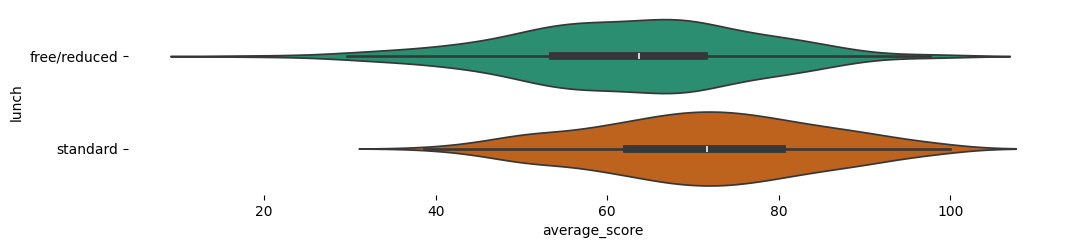

In [32]:
# @title lunch vs average_score

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(student_df['lunch'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(student_df, x='average_score', y='lunch', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

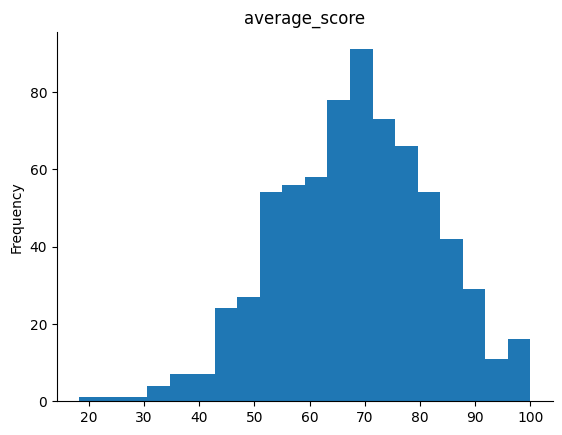

In [30]:
# @title average_score

from matplotlib import pyplot as plt
student_df['average_score'].plot(kind='hist', bins=20, title='average_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [26]:
student_df.shape

(700, 6)

In [6]:
for column in student_df.columns[student_df.dtypes == 'object']:
    unique_elements = student_df[column].unique()
    print(f"Unique elements in column '{column}': {unique_elements}")

Unique elements in column 'gender': ['male' 'female']
Unique elements in column 'race/ethnicity': ['group D' 'group C' 'group A' 'group E' 'group B']
Unique elements in column 'parental level of education': ["associate's degree" 'some college' "master's degree" 'high school'
 "bachelor's degree" 'some high school']
Unique elements in column 'lunch': ['free/reduced' 'standard']
Unique elements in column 'test preparation course': ['completed' 'none']
Unique elements in column 'gender': ['male' 'female']
Unique elements in column 'race/ethnicity': ['group D' 'group C' 'group A' 'group E' 'group B']
Unique elements in column 'parental level of education': ["associate's degree" 'some college' "master's degree" 'high school'
 "bachelor's degree" 'some high school']
Unique elements in column 'lunch': ['free/reduced' 'standard']
Unique elements in column 'test preparation course': ['completed' 'none']


In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

In [10]:
X = student_df.drop('average_score', axis=1)
y = student_df['average_score']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
ordinal_cols =['parental level of education','test preparation course','lunch']

categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].dtype == "object" and cname not in ordinal_cols]

education_mapping ={"associate's degree" :4,
                    'some college':3,
                     "master's degree" :6,
                    'high school' :2,
                    "bachelor's degree" :5,
                    'some high school' :1
}

prep_mapping ={
    'completed' :2,
    'none':1
}

lunch_mappping={
    'free/reduced' :1,
    'standard':2
}

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures

In [16]:
categorical_transformer = Pipeline(steps=[

    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_transformer = Pipeline(steps=[
       ('ordinal', OrdinalEncoder(categories=[list(education_mapping.keys()),
       list(prep_mapping.keys()),
       list(lunch_mappping.keys())]))
  ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
    ],
    remainder='drop'
)

In [17]:
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['gender', 'race/ethnicity']),
                                ('ord',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(categories=[["associate's "
                                                                              'degree',
                                                                              'some '
                                                                              'college',
                                                                              "master's "
                                                                              'degree',
                                                                              'high '
                                                                              'school',
                                                                              "bachelor's "
                                                                              'degree',
                                                                              'some '
                                                                              'high '
                                                                              'school'],
                                                                             ['completed',
                                                                              'none'],
                                                                             ['free/reduced',
                                                                              'standard']]))]),
                                 ['parental level of education',
                                  'test preparation course', 'lunch'])])

In [18]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid = scaler.transform(y_valid.values.reshape(-1, 1))

In [27]:
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(random_state=42))
])

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Number of trees
    'classifier__max_depth': [None, 10, 20],  # Tree depth
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples to split
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum samples at a leaf node
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the GridSearchCV pipeline on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_valid, y_valid)
print("Test Set Accuracy:", test_score)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best Cross-Validation Accuracy: -0.8684042105731719
Test Set Accuracy: 0.1421774805931746


In [51]:
from sklearn.metrics import mean_squared_error

y_pred = best_model.predict(X_valid)

# Inverse transform to get predictions and actual values in original scale
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_valid_original = scaler.inverse_transform(y_valid.reshape(-1, 1))

# Calculate MSE in original scale
mse = mean_squared_error(y_valid_original, y_pred_original)

# Calculate RMSE from MSE
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 13.558157643946055
